# Используемые библиотеки

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [184]:
df = pd.read_csv('data\data_set_to_train.csv')

X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]
X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

X_final = pd.read_csv('data\data_set_to_test_X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 13828
Строк в тесте 6812


In [185]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [186]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [187]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [188]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [189]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float32 
 1   latitude            13828 non-null  float32 
 2   housing_median_age  13349 non-null  float32 
 3   total_rooms         13828 non-null  float32 
 4   total_bedrooms      13828 non-null  float32 
 5   population          13429 non-null  float32 
 6   households          13828 non-null  float32 
 7   median_income       13828 non-null  float32 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float32(8)
memory usage: 553.9 KB


In [102]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [103]:
X.shape

(13828, 9)

In [104]:
X[['longitude', 'latitude']].head(5)

,longitude,latitude
Id,,
5088,-118.279999,33.980000
17096,-122.230003,37.459999
5617,-118.260002,33.790001
20060,-119.260002,35.869999
895,-121.959999,37.540001


## Переменные

In [105]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


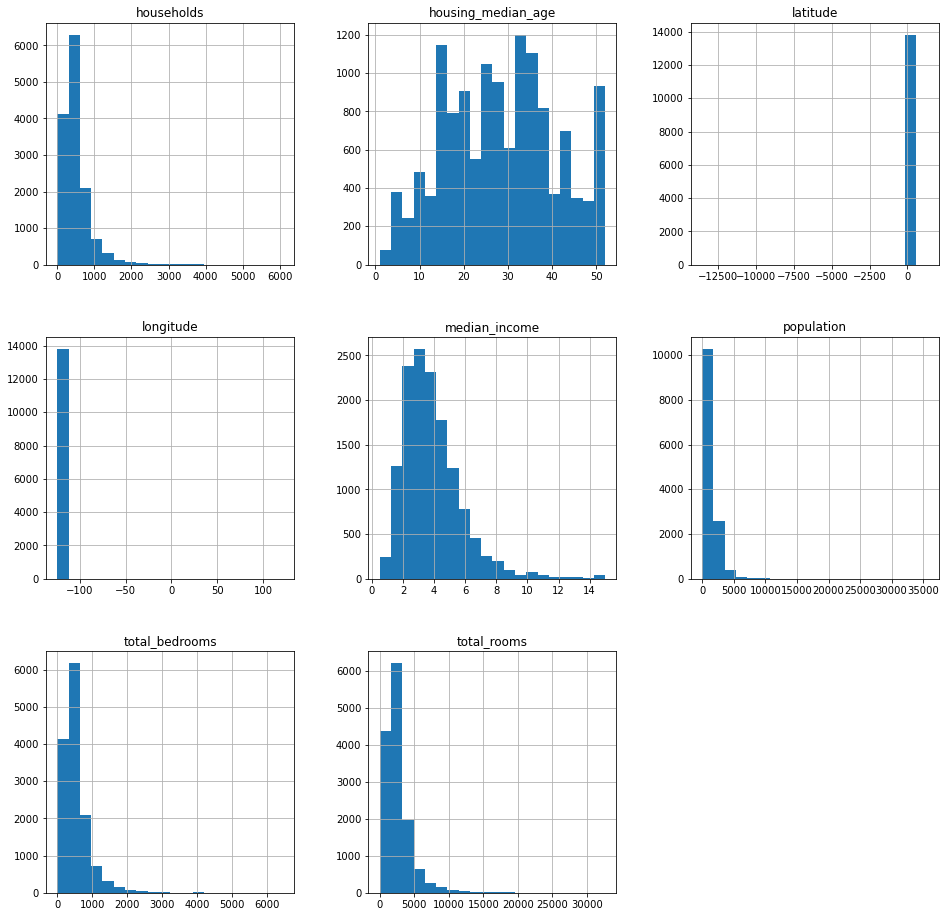

In [16]:
X.hist(figsize=(16,16), bins=20);

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.009715           -0.039775     0.035243   
latitude            -0.009715  1.000000           -0.011278     0.005695   
housing_median_age  -0.039775 -0.011278            1.000000    -0.361614   
total_rooms          0.035243  0.005695           -0.361614     1.000000   
total_bedrooms       0.043869  0.006314           -0.321267     0.929825   
population           0.060158  0.006036           -0.290628     0.855977   
households           0.039350  0.006354           -0.302934     0.920828   
median_income       -0.003205 -0.018312           -0.115285     0.197146   

                    total_bedrooms  population  households  median_income  
longitude                 0.043869    0.060158    0.039350      -0.003205  
latitude                  0.006314    0.006036    0.006354      -0.018312  
housing_median_age       -0.321267   -0.290628   -0.302934      -0.115285  
total_rooms

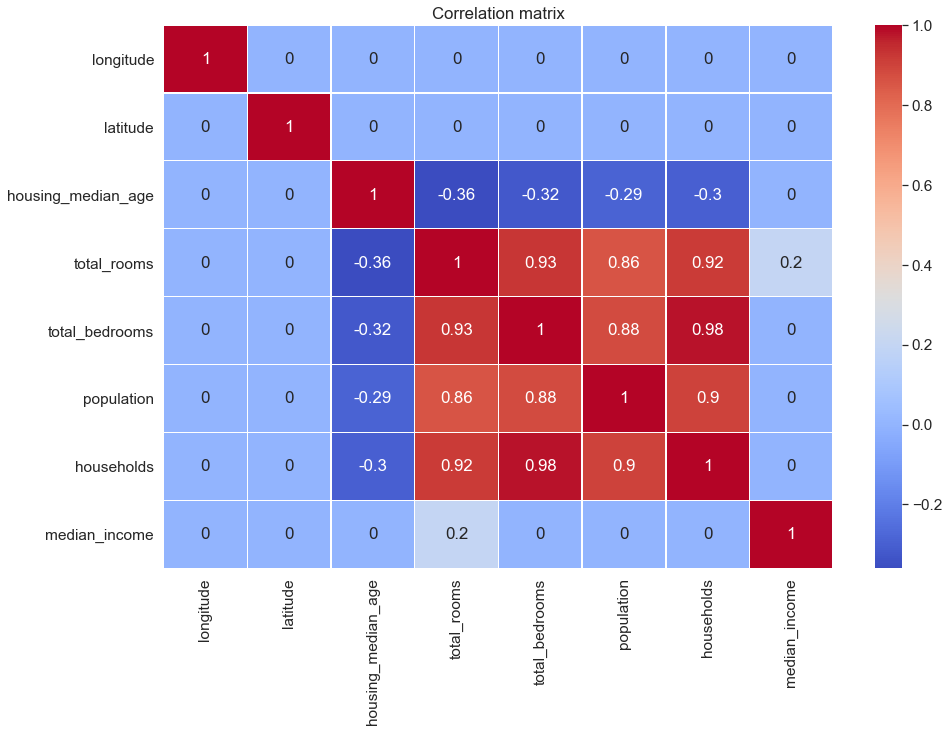

In [17]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

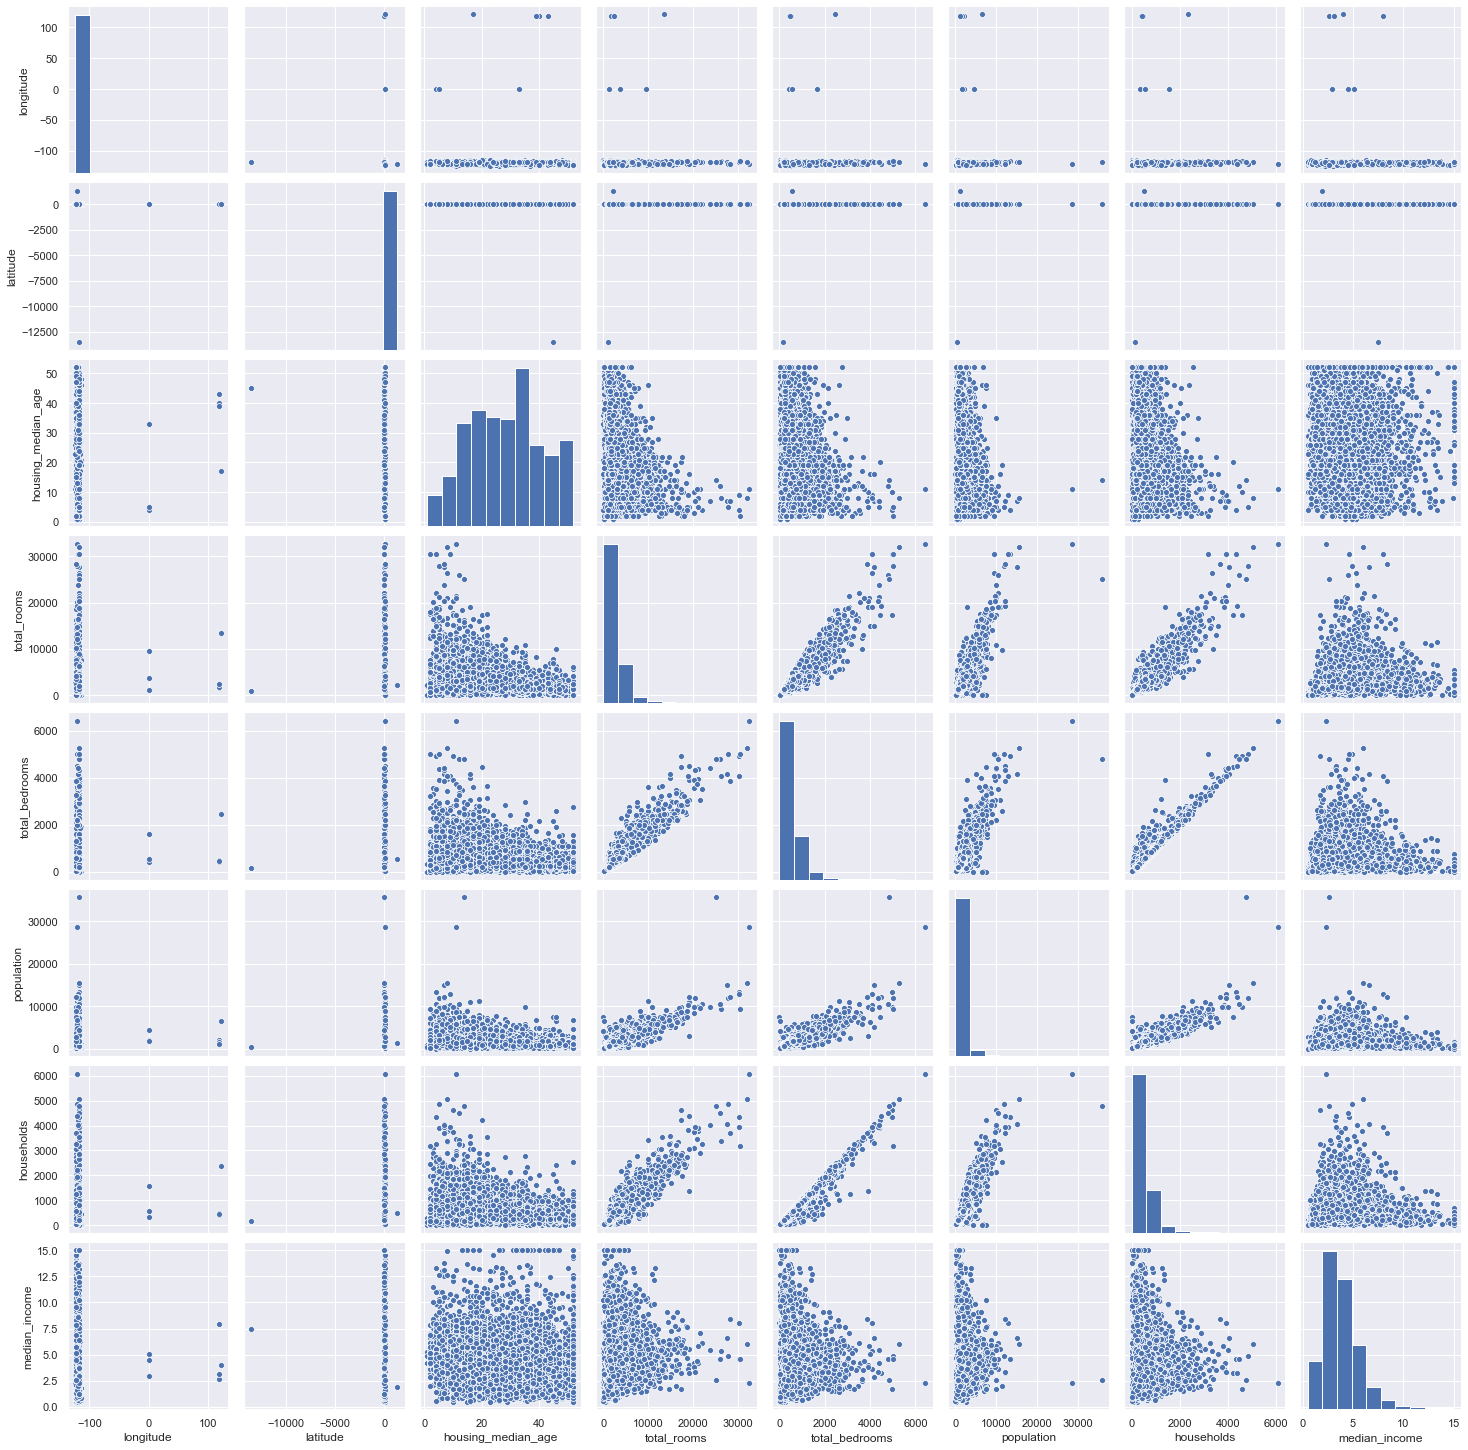

In [18]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

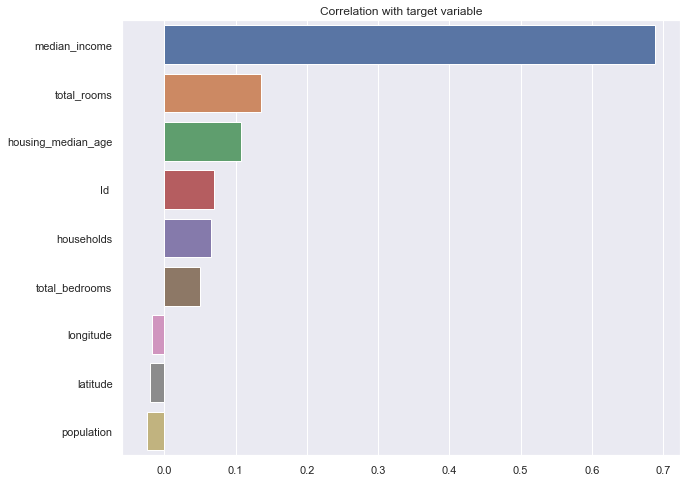

In [19]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [20]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

# Исправляем и дополняем

In [190]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [191]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

In [192]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1
X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1

In [193]:
X.loc[X['longitude'] == 0, 'longitude'] = X['longitude'].median()
X_final.loc[X_final['longitude'] == 0, 'longitude'] = X_final['longitude'].median()

In [194]:
median = X['latitude'].median()
X.loc[X['latitude'] < 0, 'latitude'] = median
X_final.loc[X_final['latitude'] < 0, 'latitude'] = median

In [195]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

In [196]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [197]:
X['room_per_household'] = X['total_rooms'] / X['households']
X_final['room_per_household'] = X_final['total_rooms'] / X_final['households']

In [198]:
X['total_income'] = X['households'] * X['median_income']
X_final['total_income'] = X_final['households'] * X_final['median_income']

In [199]:
X.loc[X['total_bedrooms'] >= X['total_rooms'] ].head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income
Id,,,,,,,,,,,,,,,,,,
3126,-117.790001,35.209999,4.0,2.0,2.0,6.0,2.0,2.375,INLAND,0,0,1,0,0,0,3.000000,1.000000,4.750
19435,-121.040001,37.669998,16.0,19.0,19.0,166.0,9.0,0.536,INLAND,0,0,1,0,0,0,8.736842,2.111111,4.824


In [200]:
X['bedroom_per_room'] = X['total_bedrooms'] / X['total_rooms']
X_final['bedroom_per_room'] = X_final['total_bedrooms'] / X_final['total_rooms']

In [157]:
X.loc[X['latitude'] > 200, 'latitude'] = 39.000000
X_final.loc[X_final['latitude'] > 200, 'latitude'] = 39.000000

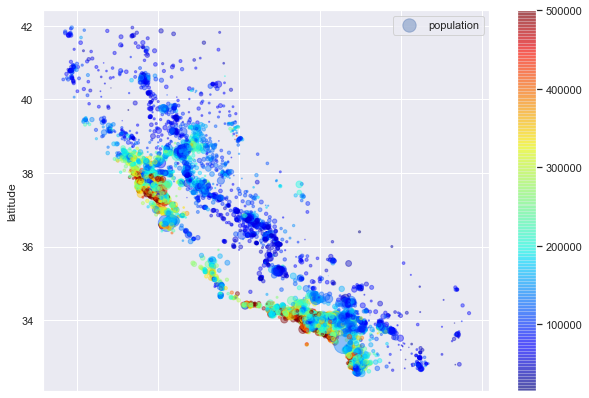

In [158]:
X.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=X['population']/100, label='population', figsize=(10,7), 
    c=y['median_house_value'], cmap=plt.get_cmap('jet'), colorbar=True)

In [201]:
X['income_category'] = np.ceil(X['median_income'])
X_final['income_category'] = np.ceil(X_final['median_income'])

In [202]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,-,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,population_per_room,room_per_household,total_income,bedroom_per_room,income_category
Id,,,,,,,,,,,,,,,,,,,,
5088,-118.279999,33.980000,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,0,1,0,0,0,0,0.822197,3.187726,271.709290,0.354473,1.0
17096,-122.230003,37.459999,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,0,0,0,0,0,1,0.384033,6.189695,1803.306274,0.175558,5.0
5617,-118.260002,33.790001,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,0,1,0,0,0,0,0.898451,4.821577,855.260803,0.227194,4.0
20060,-119.260002,35.869999,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,0,0,1,0,0,0,1.060377,4.274194,612.646851,0.245283,2.0
895,-121.959999,37.540001,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,0,1,0,0,0,0,0.536232,4.608303,4421.917480,0.236389,4.0


In [203]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'population_per_room', 'room_per_household',
       'total_income', 'bedroom_per_room', 'income_category'],
      dtype='object')

# Проверяем модель

In [204]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'population_per_room', '-', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'room_per_household']

X = X[remain_features]
X_final = X_final[remain_features]

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
maximum = 0
maxi = 0
maxj = 0
maxk = 0
summary = 11 * 8 * 31
count = 0
for i in range(10, 21, 1):
    for k in range(200, 351, 5):
        model = LGBMRegressor(max_depth=i,
                 n_estimators=k,
                 random_state=42)
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        score = r2(y_test['median_house_value'], y_pred_test)
        if score > maximum:
            maximum = score
            maxi = i
            maxk = k
        count += 1
        print(f"i: {i}   k: {k}   score: {round(score, 4)}    {round(count * 100 / summary, 2)} %")

print(f"(max_depth={maxi}, n_estimators={maxk}, random_state=42))")
print(f"score: {maximum}")

In [206]:
model = LGBMRegressor(max_depth=16,
                             min_samples_leaf=5,
                             n_estimators=295,
                             random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(max_depth=16, min_samples_leaf=5, n_estimators=295,
              random_state=42)

In [207]:
y_pred_test = model.predict(X_test)

In [208]:
for i in range(len(y_pred_test)):
    if y_pred_test[i] > 500000:
        y_pred_test[i] = 500001

R2:	0.83343
RMSE:	46911.38
MSE:	2200677571.374


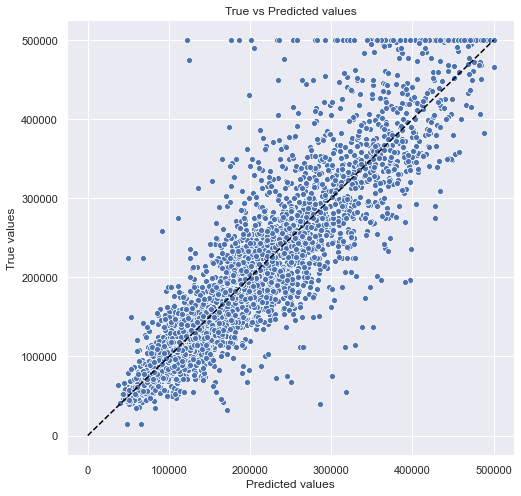

In [209]:
evaluate_preds(y_test['median_house_value'], y_pred_test)

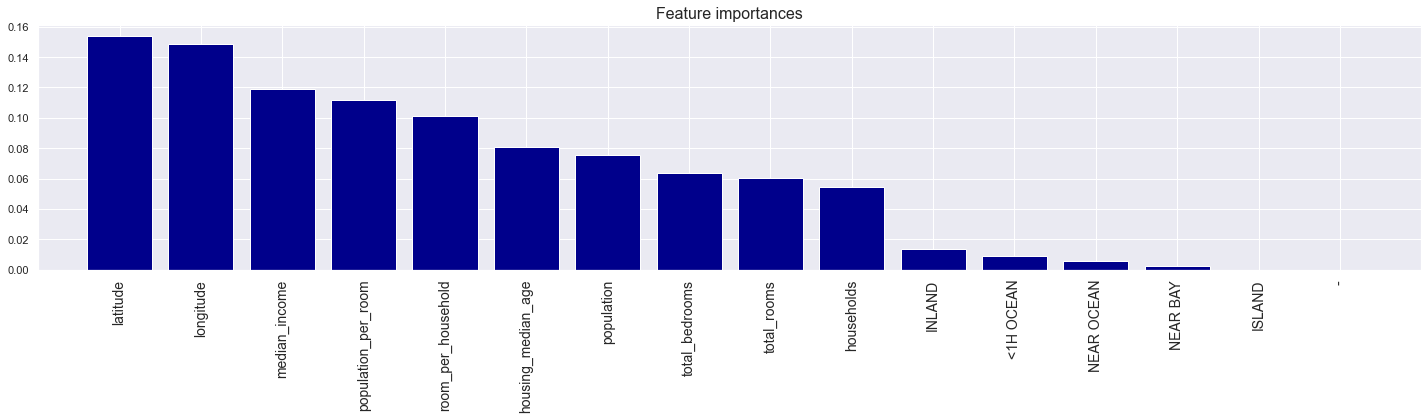

In [210]:
plot_feature_importances(importances = model.feature_importances_, X=X)

## Учим финальную модель

In [211]:
model.fit(X, y)

LGBMRegressor(max_depth=16, min_samples_leaf=5, n_estimators=295,
              random_state=42)

In [213]:
y_pred = model.predict(X_final)

In [214]:
for i in range(len(y_pred)):
    if y_pred[i] > 500000:
        y_pred[i] = 500001

In [215]:
y_pred_df = pd.DataFrame(y_pred, columns=['median_house_value'])

In [216]:
y_pred_df

,median_house_value
0,68952.463989
1,124795.070060
2,500001.000000
3,372958.547551
4,315966.867714
...,...
6807,166803.460020
6808,127653.197222
6809,124914.828443
6810,134136.515352


In [217]:
X_final.index

Int64Index([20046,  3024, 15663, 20484,  9814, 13311,  7113,  7668, 18246,
             5723,
            ...
             6557,  3383, 16201, 18186,  3592, 15316, 14772, 12870, 13476,
            16123],
           dtype='int64', name='Id ', length=6812)

In [218]:
filename = '201115_Reznik_1.csv'
y_pred_df.to_csv(filename, index=None)